In [1]:
import warnings

import astropy.units
import FunctionLib as FL
import inspect
from tqdm import tqdm
import astropy
import wave
from matplotlib.image import resample
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict
import re
import scipy

mpl.rcParams['font.family'] = 'serif'


warnings.filterwarnings("ignore")

DJAv4Catalog = FL.Spectrum_Catalog()
DJAv4Catalog.load_from_pkl(os.path.expanduser(
    '~/DustCurve/DJAv4Catalog.pkl'))

DJAv4Catalog.to_dataframe()


,survey_id_subid,survey_id,prism_filepath,prism_redshift,grating_filepaths,grating_redshifts,determined_redshift,file_count,available_filters,properties
0,snh0pe-v4_4446_102,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,0.2259,{'g140m-f100lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g140m-f100lp': nan, 'g235m-f170lp': nan}",0.2259,3,"{g140m-f100lp, prism-clear, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
1,snh0pe-v4_4446_143,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,1.6318,{'g140m-f100lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g140m-f100lp': 1.6313, 'g235m-f170lp': 1.6309}",1.6311,3,"{g140m-f100lp, prism-clear, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
2,snh0pe-v4_4446_285,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,0.4446,{'g140m-f100lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g140m-f100lp': 0.4462, 'g235m-f170lp': 0.4462}",0.4462,3,"{g140m-f100lp, prism-clear, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
3,snh0pe-v4_4446_29,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,1.7834,{'g140m-f100lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g140m-f100lp': 1.7799, 'g235m-f170lp': 1.7796}",1.77975,3,"{g140m-f100lp, prism-clear, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
4,snh0pe-v4_4446_123,snh0pe-v4,/home/xingyaocai/DJAv4/snh0pe-v4/snh0pe-v4_pri...,1.7855,{'g140m-f100lp': '/home/xingyaocai/DJAv4/snh0p...,"{'g140m-f100lp': 1.7855, 'g235m-f170lp': 1.7851}",1.7855,3,"{g140m-f100lp, prism-clear, g235m-f170lp}","{'redshift_conflict': False, 'Sample_Flag': Fa..."
...,...,...,...,...,...,...,...,...,...,...
32564,ceers-ddt-v4_2750_1636,ceers-ddt-v4,/home/xingyaocai/DJAv4/ceers-ddt-v4/ceers-ddt-...,3.0592,{},{},3.0592,1,{prism-clear},"{'redshift_conflict': False, 'Sample_Flag': Fa..."
32565,ceers-ddt-v4_2750_3213,ceers-ddt-v4,/home/xingyaocai/DJAv4/ceers-ddt-v4/ceers-ddt-...,4.8013,{},{},4.8013,1,{prism-clear},"{'redshift_conflict': False, 'Sample_Flag': Fa..."
32566,ceers-ddt-v4_2750_340,ceers-ddt-v4,/home/xingyaocai/DJAv4/ceers-ddt-v4/ceers-ddt-...,0.9585,{},{},0.9585,1,{prism-clear},"{'redshift_conflict': False, 'Sample_Flag': Fa..."
32567,ceers-ddt-v4_2750_21413,ceers-ddt-v4,/home/xingyaocai/DJAv4/ceers-ddt-v4/ceers-ddt-...,2.1402,{},{},2.1402,1,{prism-clear},"{'redshift_conflict': False, 'Sample_Flag': Fa..."


In [2]:
number_no_prism = 0
number_no_grating = 0
number_prism_out_of_range = 0
nohalpha=0
nohbeta=0
noalphaandbeta=0
samplenum=0
notsamplenum=0
errorfilenum=0

for id, catalog in tqdm(DJAv4Catalog.catalog_iterator(), desc='Processing DJAv4Catalog'):
    if catalog['properties'].get('Sample_Reason') == 'No Grating Spectrum':
        number_no_grating += 1
    if catalog['properties'].get('Sample_Reason') == 'No Prism Spectrum':
        number_no_prism += 1
    if catalog['properties'].get('Sample_Reason') == 'Prism Spectrum Boundarys Not In UV Range' or catalog['properties'].get('Sample_Reason')=='Prism Spectrum Boundarys Not Found':
        number_prism_out_of_range += 1
    if catalog['properties'].get('Sample_Reason') == 'Grating no H-beta Coverage':
        nohbeta += 1
    if catalog['properties'].get('Sample_Reason') == 'Grating no H-alpha Coverage':
        nohalpha += 1
    if catalog['properties'].get('Sample_Reason') == 'Grating no H-alpha and H-beta Coverage' or catalog['properties'].get('Sample_Reason') == 'Grating Spectrum Boundarys Not Found':
        noalphaandbeta += 1

    if catalog['properties'].get('Sample_Flag')==True:
        samplenum += 1
    if catalog['properties'].get('Sample_Flag')==False:
        notsamplenum += 1
    if catalog['properties'].get('Sample_Reason').startswith('Error'):
        errorfilenum += 1
print(f'{"%"*60}')
print(f'Number of samples with no grating spectrum: {number_no_grating}')
print(f'Number of samples with no prism spectrum: {number_no_prism}')
print(f'Number of samples with prism spectrum out of range: {number_prism_out_of_range}')
print(f'{"%"*60}')
print(f'Number of samples with no H-beta coverage: {nohbeta}')
print(f'Number of samples with no H-alpha coverage: {nohalpha}')
print(f'Number of samples with no H-alpha and H-beta coverage: {noalphaandbeta}')
print(f'{"%"*60}')
print(f'Number of samples with valid properties: {samplenum}')
print(f'Number of samples with invalid properties: {notsamplenum}')
print(f'Number of samples with error in properties: {errorfilenum}')
print(f'{"%"*60}')
print(f'{"%"*60}')

Processing DJAv4Catalog: 32569it [00:00, 618608.79it/s]

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Number of samples with no grating spectrum: 13497
Number of samples with no prism spectrum: 5705
Number of samples with prism spectrum out of range: 8465
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Number of samples with no H-beta coverage: 692
Number of samples with no H-alpha coverage: 573
Number of samples with no H-alpha and H-beta coverage: 39
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Number of samples with valid properties: 3598
Number of samples with invalid properties: 28971
Number of samples with error in properties: 0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [3]:
def power_law_fit(x, a, b):
    return a * (x ** b)

In [11]:
count = 0
beta_fit_results_amplitude = []
beta_fit_results_lambda = []
beta_err=[]
for id, catalog in tqdm(DJAv4Catalog.catalog_iterator(), desc='Processing DJAv4Catalog'):
    if catalog['properties'].get('Sample_Flag'):
        Prism_Spectrum=FL.Load_Spectrum_From_Fits(catalog.get('prism_filepath'),redshift=catalog.get('determined_redshift'))
        Prism_Spectrum.set_boundarys(125*astropy.units.nm, 260*astropy.units.nm)


        wave=Prism_Spectrum.processing_wavelengths.convert_unit_to(astropy.units.AA).data
        flux=Prism_Spectrum.processing_flux.data

        amplitude_guess= np.max(flux)
        lambda_guess = -1
        initial_guess = [amplitude_guess, lambda_guess]

        try:
            popt, pcov = scipy.optimize.curve_fit(power_law_fit, wave, flux, p0=initial_guess,maxfev=1000000)
        except Exception as e:
            print(f"Error fitting power law for ID {id}: {e}")
            continue
        beta_fit_results_amplitude.append(popt[0])
        beta_fit_results_lambda.append(popt[1])
        beta_err.append(np.sqrt(np.diag(pcov)))


        # if np.sqrt(np.diag(pcov))[1]>0.25:
        #     continue
        # print(f"ID: {id}, Amplitude: {a}, Lambda: {b}")
        # print(f"Fitted parameters: {np.sqrt(np.diag(pcov))}")


        # fig,ax=Prism_Spectrum.show(False)
        # #set x and y scale 1 to 1
        # #ax.set_aspect('equal')
        # ax.set_xscale('log')
        # ax.set_yscale('log')
        # ax.set_title(f"DJAv4 Prism Spectrum {id}")
        # ax.plot(wave, power_law_fit(wave, *popt), color='red', label='Power Law Fit')
        # ax.legend()

        # plt.show()
















        # count += 1

        # if count == 30:
        #     break





Processing DJAv4Catalog: 32569it [00:40, 795.34it/s] 


In [22]:
beta_fit_results_amplitude = np.array(beta_fit_results_amplitude)
beta_fit_results_lambda = np.array(beta_fit_results_lambda)
beta_err = np.array(beta_err)

In [23]:
large_error_indices = np.where(np.array(beta_err)[:,1] > 0.3)[0]
small_error_indices = np.where(np.array(beta_err)[:,1] <= 0.3)[0]
print(f'Number of samples with small error in beta fit: {len(small_error_indices)}')
print(f'Number of samples with large error in beta fit: {len(large_error_indices)}')

Number of samples with small error in beta fit: 1022
Number of samples with large error in beta fit: 2576


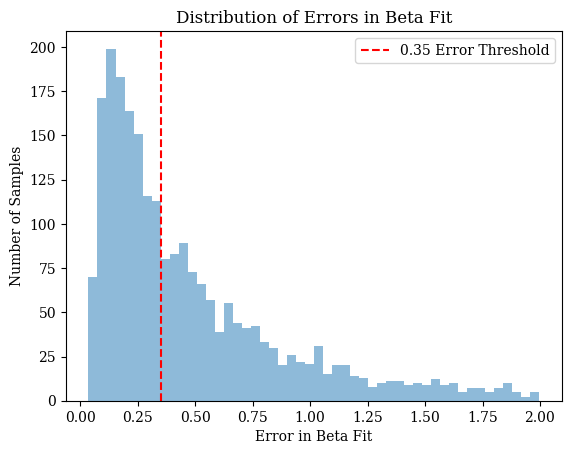

In [37]:
plt.hist(beta_err[np.where(beta_err[:,1]<2)][:,1], bins=50, alpha=0.5)
plt.xlabel('Error in Beta Fit')
plt.ylabel('Number of Samples')
plt.title('Distribution of Errors in Beta Fit')
plt.axvline(x=0.35, color='red', linestyle='--', label='0.35 Error Threshold')
plt.legend()


Text(0.5, 1.0, 'Distribution of Lambda Values for Small Error in Beta Fit')

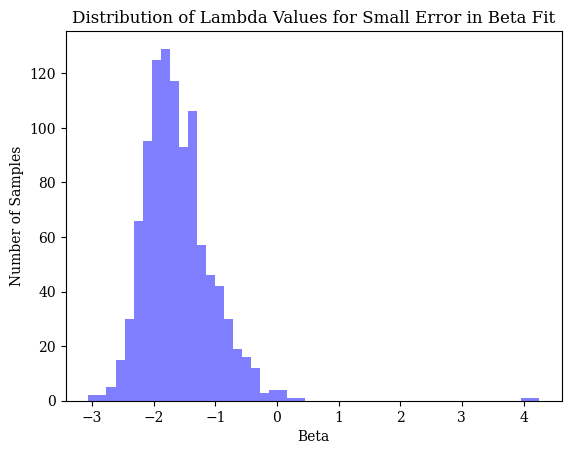

In [38]:
plt.hist(beta_fit_results_lambda[small_error_indices], bins=50, alpha=0.5, label='Small Error', color='blue')
plt.xlabel('Beta')
plt.ylabel('Number of Samples')
plt.title('Distribution of Lambda Values for Small Error in Beta Fit')